<a href="https://colab.research.google.com/github/Manojksen/SEMS-STrategy/blob/main/dam__us50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement** - Why Most Investors Underperform
 The Common Pitfalls:-

*  Decisions are based on emotions, not on historical data
*  No logic for timing entry or exit (ignoring seasonality)
*  Risk is spread unevenly across stocks
*  Buy-and-hold approach ignores short-term market behavior

 **Result:**-
*    Low returns
*    High drawdowns
*    Unbalanced portfolios


 Bottom Line: Even good stocks can give bad results if timing and risk aren't managed.






---

**Project Objective - SEMS Strategy**

**SEMS: Seasonal Edge Macro Strategy**

 Goal: Answer one key question - "When are stocks most likely to perform well - statistically?"

**Core Ideas**:-

*  Analyze 15+ years of monthly return patterns
*  Identify high-performing months per stock
*  Only invest during those strong months
*  Use daily-level stop-loss and take-profit to guard against shocks
*  Distribute capital based on Sharpe-optimal weighting
*  Analogy: Act like a farmer: Only sow seeds (capital) during fertile seasons (months).
* Use professional hedging strategies on underperforming stocks to manage downside risk



---
**How the SEMS Model Works**

 Step-by-Step Breakdown:

1. **Monthly Return Analysis:** Analyze 15 years of historical data by calculating weighted average monthly returns to identify statistically strong months.

2. **Signal Generation:** Generate entry signals by selecting only those months with consistently strong performance.

3. **Capital Protection:** Apply stop-loss (SL) to limit downside risk and take-profit (TP) to secure gains.

4. **Portfolio Optimization:** Allocate capital using weights optimized for the highest Sharpe Ratio.

5.**Backtesting:** Evaluate performance across 50 major U.S. stocks and benchmark against SPY.



---
**Project Results & Insights**:

 Backtest Results vs SPY:-

*   Cumulative Returns: SEMS Higher
*   Volatility: SEMS Lower
*   Max Drawdown: SEMS Smaller
*   Win Ratio: SEMS Higher
*   Risk-Adjusted Return: SEMS Improved

**Insights:** SEMS delivers better returns with lower risk.
Fewer trades, smarter entries. Capital preserved by protection rules.
   


---
**Final Summary- What Makes SEMS Unique-**


*   Rules-based investing, not emotion-based
*   Data-driven entry/exit using long-term seasonal trends
*   Daily-level SL/TP protection
*   Scientific capital allocation using risk models
*   Modular, flexible, scalable across markets


SEMS answers: "When should I be in the market, and when should I stay out?"



---

**Improvements & Next Steps**



*   Use standard deviation and volatility to detect market regimes and generate signals.
*   Apply machine learning to forecast monthly returns and identify regime shifts.
*   Incorporate portfolio-level Value at Risk (VaR) for dynamic risk management
*   **Next:** Move from backtesting to live trading deployment.

---



















In [ ]:
!pip install yfinance --upgrade
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import datetime
from scipy.optimize import minimize

In [ ]:
all_tickers= [
    # US 50 stocks different sectors
    "AAPL", "MSFT", "GOOGL", "META", "NVDA",
    "AMZN", "TSLA", "HD", "MCD", "NKE",

    "JPM", "BAC", "WFC", "GS", "MS",

    "UNH", "JNJ", "PFE", "LLY", "MRK",

    "HON", "UNP", "UPS", "GE", "CAT",

    "PG", "KO", "PEP", "WMT", "COST",

    "XOM", "CVX", "SLB", "COP", "EOG",

    "NFLX", "DIS", "TMUS", "VZ", "T",

    "NEE", "DUK", "SO", "EXC", "AEP",

    "PLD", "AMT", "CCI", "O", "SPG"
]

In [ ]:
#2. Download prices
end =datetime.date(2025, 4, 30)
#end =datetime.date.today()
start= end-datetime.timedelta(days=365*15)
prices = yf.download(all_tickers, start=start, end=end)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  50 of 50 completed


In [ ]:
# Compute daily % returns for each ticker
daily_returns = prices.pct_change() * 100  # multiply by 100 to get %
daily_returns = daily_returns.dropna()

In [ ]:
#Monthly Return
monthly_returns = prices.resample('M').last().pct_change()* 100

# Resample to monthly close prices
monthly_close = prices.resample('M').last()

# Calculate monthly returns
monthly_returns = monthly_close.pct_change() * 100

# Reshape into long format
monthly_returns_melted = monthly_returns.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Monthly Return %')

# Add Year and Month columns
monthly_returns_melted['Year'] = monthly_returns_melted['Date'].dt.year
monthly_returns_melted['Month'] = monthly_returns_melted['Date'].dt.strftime('%B')

# Drop missing values
monthly_returns_melted = monthly_returns_melted.dropna(subset=['Monthly Return %'])

data=monthly_returns_melted


<ipython-input-5-2963301aeaed>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = prices.resample('M').last().pct_change()* 100
<ipython-input-5-2963301aeaed>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_close = prices.resample('M').last()


In [ ]:
data

,Date,Ticker,Monthly Return %,Year,Month
1,2010-06-30,AAPL,-2.082728,2010,June
2,2010-07-31,AAPL,2.274138,2010,July
3,2010-08-31,AAPL,-5.500478,2010,August
4,2010-09-30,AAPL,16.721520,2010,September
5,2010-10-31,AAPL,6.072223,2010,October
...,...,...,...,...,...
8995,2024-12-31,XOM,-8.808072,2024,December
8996,2025-01-31,XOM,-0.687924,2025,January
8997,2025-02-28,XOM,5.144445,2025,February
8998,2025-03-31,XOM,6.826550,2025,March


In [ ]:
 data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
# Positive/Negative months
data['pos'] = data['Monthly Return %'] > 0
data['neg'] = data['Monthly Return %'] < 0

pos_counts = data.groupby(['Ticker', 'Month'])['pos'].sum().reset_index()
neg_counts = data.groupby(['Ticker', 'Month'])['neg'].sum().reset_index()
latest_year = data['Year'].max()

In [ ]:
avg_15y = data[data['Year'] >= latest_year - 14].groupby(['Ticker', 'Month'])['Monthly Return %'].mean().reset_index().rename(columns={'Monthly Return %': '15Y Avg'})
avg_10y = data[data['Year'] >= latest_year - 9].groupby(['Ticker', 'Month'])['Monthly Return %'].mean().reset_index().rename(columns={'Monthly Return %': '10Y Avg'})
avg_5y  = data[data['Year'] >= latest_year - 4].groupby(['Ticker', 'Month'])['Monthly Return %'].mean().reset_index().rename(columns={'Monthly Return %': '5Y Avg'})
total_avg = data.groupby(['Ticker', 'Month'])['Monthly Return %'].mean().reset_index().rename(columns={'Monthly Return %': 'Total Avg'})

In [ ]:
dfs = [avg_15y, avg_10y, avg_5y, total_avg, pos_counts, neg_counts]

from functools import reduce

In [ ]:
# Merge all averages into one DataFrame
average_summary = reduce(lambda left, right: pd.merge(left, right, on=['Ticker', 'Month'], how='outer'),
                         [pos_counts,neg_counts,avg_15y, avg_10y, avg_5y, total_avg])

# Sort months properly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
average_summary['Month'] = pd.Categorical(average_summary['Month'], categories=month_order, ordered=True)
average_summary = average_summary.sort_values(['Ticker', 'Month'])

df= average_summary
# Display the final merged DataFrame
average_summary.head()


,Ticker,Month,pos,neg,15Y Avg,10Y Avg,5Y Avg,Total Avg
4,AAPL,January,7,8,0.328247,0.605288,-0.210059,0.328247
3,AAPL,February,9,6,2.598222,0.274856,-2.065310,2.598222
7,AAPL,March,9,6,1.861336,1.957886,1.013504,1.861336
0,AAPL,April,8,7,0.620934,0.090066,-0.955845,0.620934
8,AAPL,May,9,5,3.114777,3.409695,1.782179,3.114777


In [ ]:
# Filter only for May
may_data = average_summary[average_summary['Month'] == 'May']

# Top 10: Strong historical performance in May
top_5 = may_data[(may_data['pos'] >= 8) &
                 (may_data['Total Avg'] > 0)].sort_values(by='Total Avg', ascending=False).head(5)

# Bottom 5: Weak historical performance in May
bottom_5 = may_data[(may_data['neg'] >= 8) &
                    (may_data['Total Avg'] < 0)].sort_values(by='Total Avg').head(5)

# Display
print("Top 5 May Performers:\n", top_5[['Ticker', 'pos', 'Total Avg']])
print("\nBottom 5 May Performers:\n", bottom_5[['Ticker', 'neg', 'Total Avg']])


Top 5 May Performers:
     Ticker  pos  Total Avg
380   NVDA   12  11.145008
356   NFLX   10   7.593951
500   TMUS   11   4.858967
272    LLY   10   3.465615
188  GOOGL    9   3.194769

Bottom 5 May Performers:
     Ticker  neg  Total Avg
476    SPG    8  -1.559161
128    DIS    9  -1.558119
452    SLB    9  -1.509804
392      O    9  -1.429159
428     PG    8  -1.368217


In [ ]:
# === Strategy Logic ===(Without Portfolio optimisation)

# Buy signal: historically strong months
buy_signals = df[
    (df['pos'] >= 8) &
    (df['Total Avg'] > 1.0) &
    ((df['5Y Avg'] > 1.0) | (df['10Y Avg'] > 1.0))
].copy()
buy_signals['Signal'] = 'Buy'

# Sell signal: historically weak months
sell_signals = df[
    (df['neg'] >= 10) &
    (df['Total Avg'] < -1.0) &
    ((df['5Y Avg'] < -1.0) | (df['10Y Avg'] < -1.0))
].copy()
sell_signals['Signal'] = 'Sell'

# Combine signals
signals = pd.concat([buy_signals, sell_signals], ignore_index=True)

# SL/TP Parameters
SL = -5  # -5%
TP = 10  # +10%
holding_days = 21
capital_per_month = 100000

# Simulate daily returns (replace this with actual daily return data in %)
np.random.seed(42)
signals['Simulated Daily Returns'] = [np.random.normal(loc=row['Total Avg']/21, scale=2, size=holding_days)
                                      for _, row in signals.iterrows()]

# Simulate each trade (daily SL/TP logic)
profits = []
for _, row in signals.iterrows():
    daily_returns = row['Simulated Daily Returns']
    cum_return = 0
    hit_SL = False
    hit_TP = False

    for r in daily_returns:
        cum_return += r
        if cum_return <= SL:
            cum_return = SL
            hit_SL = True
            break
        elif cum_return >= TP:
            cum_return = TP
            hit_TP = True
            break

    direction = 1 if row['Signal'] == 'Buy' else -1
    profit = capital_per_month / signals[signals['Month'] == row['Month']].shape[0] * (direction * cum_return / 100)
    profits.append(profit)

signals['Profit'] = profits

# Final monthly return
monthly_returns = signals.groupby('Month')['Profit'].sum().reset_index()
monthly_returns['Capital Used'] = capital_per_month
monthly_returns['Monthly Return %'] = monthly_returns['Profit'] / monthly_returns['Capital Used'] * 100

# CAGR calculation
avg_monthly = monthly_returns['Monthly Return %'].mean() / 100
strategy_cagr = (1 + avg_monthly) ** 12 - 1

# SPY500 reference CAGR
spy_cagr = 0.1844

# === Summary ===
print("=== Monthly Strategy Performance ===")
print(monthly_returns[['Month', 'Monthly Return %']])
print(f"\nStrategy CAGR: {strategy_cagr * 100:.2f}%")
print(f"SPY500 CAGR : {spy_cagr * 100:.2f}%")

=== Monthly Strategy Performance ===
        Month  Monthly Return %
0     January          2.425792
1    February          1.065982
2       March         -0.176846
3       April          1.516211
4         May          0.440798
5        June         -0.115499
6        July          2.454326
7      August          2.559944
8   September          3.613396
9     October          3.633675
10   November          2.802188
11   December          1.471512

Strategy CAGR: 23.98%
SPY500 CAGR : 18.44%


<ipython-input-13-939becc6b832>:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_returns = signals.groupby('Month')['Profit'].sum().reset_index()


In [ ]:
#SEMA Strategy (WITH Portfolio optimaizaion)

# Step 1: Generate Buy/Sell Signals
buy_signals = df[(df['pos'] >= 8) & (df['Total Avg'] > 1.0) & ((df['5Y Avg'] > 1.0) | (df['10Y Avg'] > 1.0))].copy()
buy_signals['Signal'] = 'Buy'

sell_signals = df[(df['neg'] >= 10) & (df['Total Avg'] < -1.0) & ((df['5Y Avg'] < -1.0) | (df['10Y Avg'] < -1.0))].copy()
sell_signals['Signal'] = 'Sell'

signals = pd.concat([buy_signals, sell_signals], ignore_index=True)
selected_tickers = signals['Ticker'].unique().tolist()

# Step 2: Use already-fetched data, select only relevant tickers
data = prices[selected_tickers].ffill().dropna()

# Step 3: Calculate optimal Sharpe ratio weights for selected tickers
daily_returns = data.pct_change().dropna()
expected_returns = daily_returns.mean() * 252
cov_matrix = daily_returns.cov() * 252

n = len(selected_tickers)
risk_free_rate = 0.0427

def portfolio_metrics(weights):
    ret = np.dot(weights, expected_returns)
    vol = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe = (ret - risk_free_rate) / vol
    return ret, vol, sharpe

def neg_sharpe(weights):
    return -portfolio_metrics(weights)[2]

constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = [(0, 0.15) for _ in range(n)]

result = minimize(neg_sharpe,
                  x0=np.ones(n)/n,
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints)

if not result.success:
    raise Exception("Optimization failed:", result.message)

optimal_weights = result.x / result.x.sum()
weights_df = pd.DataFrame({'Ticker': selected_tickers, 'Weight': optimal_weights})

# Step 4: Trade Simulation with SL/TP
capital_per_month = 100000
SL = -5
TP = 10
holding_days = 21

all_signals = []

for _, row in signals.iterrows():
    ticker = row['Ticker']
    month = row['Month']
    direction = 1 if row['Signal'] == 'Buy' else -1
    total_avg = row['Total Avg']

    if ticker not in weights_df['Ticker'].values:
        continue

    ticker_weight = weights_df[weights_df['Ticker'] == ticker]['Weight'].values[0]
    capital_allocated = capital_per_month * ticker_weight

    # Simulated returns (replace with real returns in future)
    np.random.seed(hash(f"{ticker}_{month}") % 2**32)
    simulated_returns = np.random.normal(loc=total_avg / 21, scale=2, size=holding_days)

    cum_return = 0
    for r in simulated_returns:
        cum_return += r
        if cum_return <= SL:
            cum_return = SL
            break
        elif cum_return >= TP:
            cum_return = TP
            break

    profit = capital_allocated * direction * cum_return / 100

    all_signals.append({
        'Month': month,
        'Ticker': ticker,
        'Signal': row['Signal'],
        'Capital': capital_allocated,
        'Return %': cum_return,
        'Profit': profit
    })

full_signals_df = pd.DataFrame(all_signals)

# Step 5: Performance Metrics
monthly_returns = full_signals_df.groupby('Month').agg({
    'Profit': 'sum',
    'Capital': 'sum'
}).reset_index()
monthly_returns['Monthly Return %'] = monthly_returns['Profit'] / monthly_returns['Capital'] * 100

avg_monthly = monthly_returns['Monthly Return %'].mean() / 100
strategy_cagr = (1 + avg_monthly) ** 12 - 1
spy_cagr = 0.1844

# Output
print("=== Monthly Strategy Performance ===")
print(monthly_returns[['Month', 'Monthly Return %']])
print(f"\nStrategy CAGR: {strategy_cagr * 100:.2f}%")
print(f"SPY500 CAGR : {spy_cagr * 100:.2f}%")


=== Monthly Strategy Performance ===
        Month  Monthly Return %
0       April          9.291556
1      August         -0.825920
2    December         10.000000
3    February          6.597485
4     January          2.388053
5        July          2.582789
6        June          1.233504
7       March          5.349597
8         May          6.075237
9    November          0.366891
10    October         -0.765212
11  September         -7.349397

Strategy CAGR: 41.12%
SPY500 CAGR : 18.44%


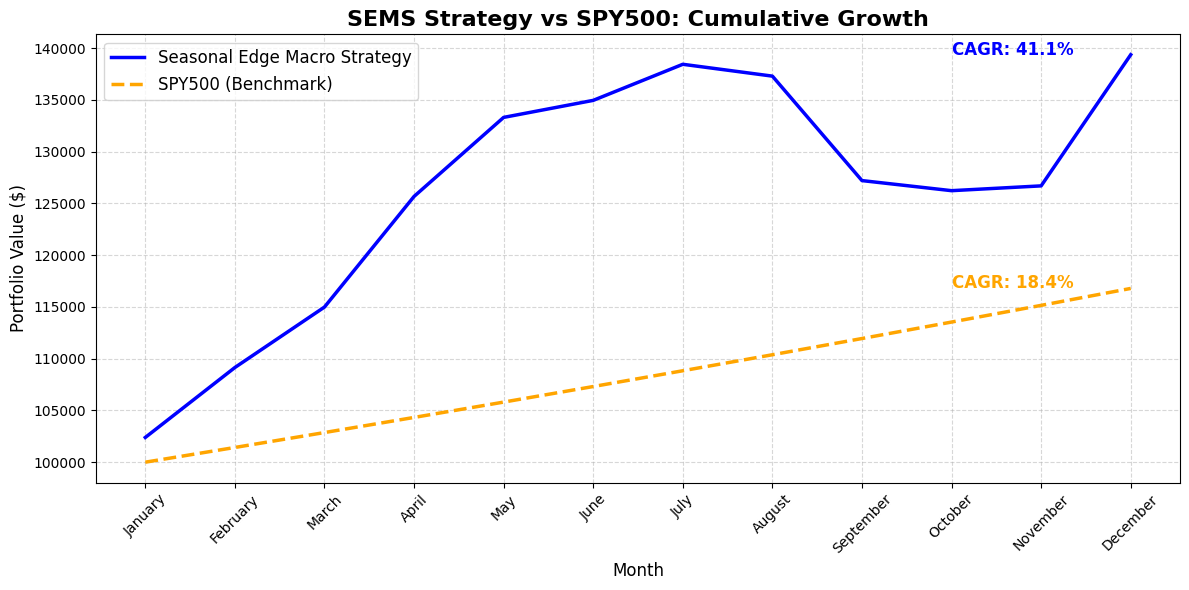

In [ ]:
# Ensure correct month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Set Month as categorical with calendar order
monthly_returns['Month'] = pd.Categorical(monthly_returns['Month'], categories=month_order, ordered=True)

# Sort by month order
monthly_returns = monthly_returns.sort_values('Month').reset_index(drop=True)

# Calculate cumulative curves
monthly_returns['Strategy Cumulative'] = (1 + monthly_returns['Monthly Return %'] / 100).cumprod() * 100_000
spy_monthly_return = (1 + spy_cagr) ** (1/12) - 1
monthly_returns['SPY500 Cumulative'] = (1 + spy_monthly_return) ** np.arange(len(monthly_returns)) * 100_000

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_returns['Month'], monthly_returns['Strategy Cumulative'], label='Seasonal Edge Macro Strategy', color='blue', linewidth=2.5)
plt.plot(monthly_returns['Month'], monthly_returns['SPY500 Cumulative'], label='SPY500 (Benchmark)', color='orange', linewidth=2.5, linestyle='--')

# Aesthetics
plt.title('SEMS Strategy vs SPY500: Cumulative Growth', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Annotate CAGR
plt.text(len(monthly_returns) - 3,
         monthly_returns['Strategy Cumulative'].iloc[-1],
         f"CAGR: {strategy_cagr*100:.1f}%",
         fontsize=12, color='blue', fontweight='bold')

plt.text(len(monthly_returns) - 3,
         monthly_returns['SPY500 Cumulative'].iloc[-1],
         f"CAGR: {spy_cagr*100:.1f}%",
         fontsize=12, color='orange', fontweight='bold')

plt.show()